[View in Colaboratory](https://colab.research.google.com/github/KHATUNA3/Week2_public/blob/master/06_SignalsML_Solutions.ipynb)

# Machine Learning with Signals Data

In this notebook we will be start using some of our machine learning techniques on signals data (audio).  We will be using a dataset consisting of recordings of spoken digits (0-9).  We will start by extracting some features from the signals and then apply our "traditional" ML algorithms, just as we did with our tabular data.  (In a future notebook we will see how to use ANNs to avoid needing to extract features.)<br><br>

If you are interested in playing around with more audio data like this, we encourage you to check out [UrbanSound](https://urbansounddataset.weebly.com).

In [47]:
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git

Cloning into 'free-spoken-digit-dataset'...
remote: Counting objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 20.90 MiB | 38.91 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
import os
os.chdir('free-spoken-digit-dataset/recordings')

In [49]:
print('{} data points\n'.format(len(os.listdir())))

# list the first few files
os.listdir()[:10]


1500 data points



['6_nicolas_47.wav',
 '8_nicolas_4.wav',
 '0_nicolas_38.wav',
 '1_nicolas_8.wav',
 '9_nicolas_7.wav',
 '2_theo_47.wav',
 '2_jackson_44.wav',
 '1_jackson_4.wav',
 '7_theo_25.wav',
 '0_jackson_29.wav']

In [50]:
import pandas as pd
import numpy as np
from scipy import signal
import scipy.io.wavfile
import scipy.stats.mstats as mstats
from IPython.display import Audio
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib
from sklearn import metrics

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16,'figure.figsize':(10,6)})

!pip install graphviz 
!apt-get install graphviz
import graphviz


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
def plot_FT(ft, T, N):
  """
  plot the Fourier Transform frequency spectrum
  :param ft: output of Fourier Transform (i.e., np.fft.fft())
  :param T: sample resolution (in seconds)
  :param N: total number of samples
  """
  
  f = np.linspace(0, 1 / T, N)
  plt.plot(f[:N // 2], np.abs(ft)[:N // 2] * 2 / N) 
  plt.ylabel("Amplitude")
  plt.xlabel("Frequency [Hz]")

Let's take a look at one of the files and see what it "looks" like.

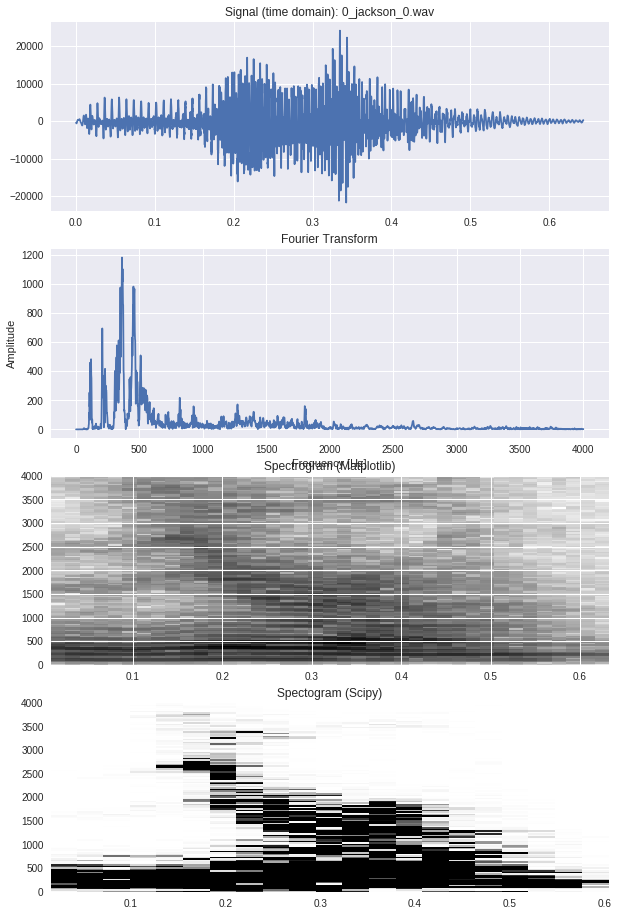

In [52]:
sample_file = '0_jackson_0.wav'

(sample_rate, y) = scipy.io.wavfile.read(sample_file)

t = np.arange(0, len(y)/sample_rate, 1/sample_rate)

# Fourier Transform
fft=np.fft.fft(y)

# Spectogram
sample_freq, segment_time, spec_data = signal.spectrogram(y,sample_rate)



# PLOT ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.figure(figsize=(10,16))

plt.subplot(4,1,1)
plt.plot(t,y)
plt.title('Signal (time domain): {}'.format(sample_file))

plt.subplot(4,1,2)
plot_FT(fft,t[1]-t[0],len(y))
plt.title('Fourier Transform')

plt.subplot(4,1,3)
specgram(y,Fs=sample_rate)
plt.title('Spectrogram (Matplotlib)')

plt.subplot(4,1,4)
plt.pcolormesh(segment_time, sample_freq, spec_data,cmap='Greys',vmax=600)
plt.title('Spectogram (Scipy)')
plt.show()

In [53]:
Audio(data=y, rate=sample_rate)

## Feature Extraction
Let's extract some features that are useful in signals processing.

### Spectral Centroid

The [**spectral centroid**](https://en.wikipedia.org/wiki/Spectral_centroid) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:
$$f_c=\frac{\sum_kA(k)f(k)}{\sum_kA(k)}$$
 
where $A(k)$ is the spectral magnitude at frequency bin $k$,  $f(k)$ is the frequency at bin $k$
 .

In [0]:
def spectral_centroid(fft,T):
  N = len(fft)
  f = np.linspace(0, 1 / T, N)
  
  freq = f[:N // 2]
  mag = np.abs(fft)[:N // 2] * 2 / N
  
  return np.sum(mag*freq)/np.sum(mag)         # return weighted sum
  

### Spectral Flatness

The [**spectral flatness**](https://en.wikipedia.org/wiki/Spectral_flatness), also known as Wiener entropy, is a measure used in digital signal processing to characterize an audio spectrum. Spectral flatness is typically measured in decibels, and provides a way to quantify how noise-like a sound is, as opposed to being tone-like.

In [0]:
def spectral_flatness(fft): 
  N = len(fft) 
  magnitude = abs(fft[:N//2])* 2 / N 
  sf = mstats.gmean(magnitude) / np.mean(magnitude) 
  
  return sf

### Maximum Frequency Value
The frequency at maximum altitude isn't necessarily a particularly informative feature, but it's easy to extract.

In [0]:
def max_freq(fft,T):
  N = len(fft)
  f = np.linspace(0, 1 / T, N)
  
  freq = f[1:N // 2]
  mag = np.abs(fft)[1:N // 2] * 2 / N
  
  return freq[np.argmax(mag)]

This what our one data point looks like in our dataframe:

In [57]:
import re


# regex the file names to get the digit, speaker, and trial
re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d.')

digit = re.match( re_digit, sample_file)[0][:-1]
speaker = re.search( re_speaker, sample_file)[0][1:-1]
trial = re.search( re_trial, sample_file)[0][1:-1]

# load into dataframe
df = pd.DataFrame(columns=['file','digit','speaker','trial','SC','SF','MF'])
sc = spectral_centroid(fft,t[1]-t[0])
sf = spectral_flatness(fft)
mf = max_freq(fft, t[1]-t[0])

df = df.append({'file':sample_file,'digit':digit,'speaker':speaker,'trial':trial,'SC':sc,'SF':sf,'MF':mf},ignore_index=True)
df

,file,digit,speaker,trial,SC,SF,MF
0,0_jackson_0.wav,0,jackson,0,849.769263,0.306077,362.15271


## Load full dataset and extract features

In [58]:
import re

re_digit = re.compile('\d+_')
re_speaker = re.compile('_[a-z]+_')
re_trial = re.compile('_\d+.')

df = pd.DataFrame(columns=['file','digit','speaker','trial','SC','SF','MF'])


for sample_file in os.listdir():
  try:
    
    digit = int(re.match( re_digit, sample_file)[0][:-1])
    speaker = re.search( re_speaker, sample_file)[0][1:-1]
    trial = int(re.search( re_trial, sample_file)[0][1:-1])

    # read the file
    (sample_rate, y) = scipy.io.wavfile.read(sample_file)
    
    # some files have two channels... just take the first
    if len(y.shape) == 2:
      y = y[:,0]
    
    t = np.arange(0, len(y)/sample_rate, 1/sample_rate)

    # Fourier Transform
    fft=np.fft.fft(y)

    # calculate features
    sc = spectral_centroid(fft,t[1]-t[0])
    sf = spectral_flatness(fft)
    mf = max_freq(fft,t[1]-t[0])

    # add to our dataframe
    df = df.append({'file':sample_file,'digit':digit,'speaker':speaker,'trial':trial,'SC':sc,'SF':sf,'MF':mf},ignore_index=True)
  
    
  except Exception as e:
    
    # something went wrong!  =(
    
    print(sample_file)
    print(e)
    
    break


/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [59]:
df.head()


,file,digit,speaker,trial,SC,SF,MF
0,6_nicolas_47.wav,6,nicolas,47,398.554889,0.154525,308.024469
1,8_nicolas_4.wav,8,nicolas,4,319.510717,0.144128,542.110358
2,0_nicolas_38.wav,0,nicolas,38,279.468209,0.115726,256.466302
3,1_nicolas_8.wav,1,nicolas,8,265.490427,0.110313,350.453172
4,9_nicolas_7.wav,9,nicolas,7,412.550950,0.172963,225.249773


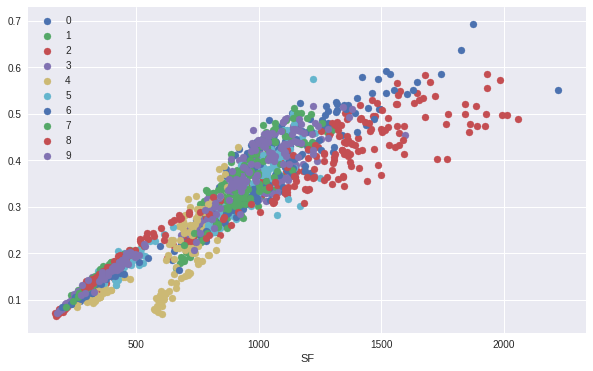

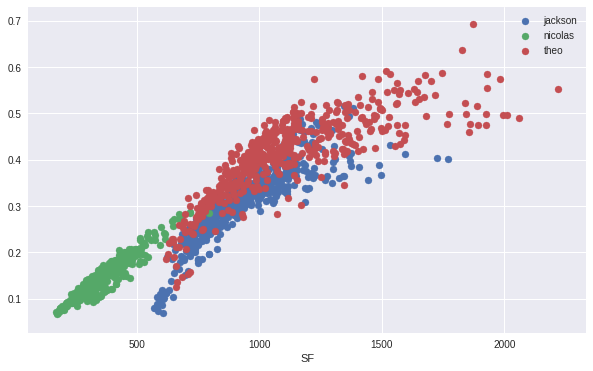

In [60]:
# PLOT THE DATA BY DIGIT AND SPEAKER

xfeature = 'SC'
yfeature = 'SF'

for label in ['digit','speaker']:

  plt.figure()
  for lbl in np.sort(df[label].unique()):

    digit_df = df[df[label]==lbl]
    plt.scatter(digit_df[xfeature],digit_df[yfeature],label='{}'.format(lbl))
    plt.xlabel(xfeature)
    plt.xlabel(yfeature)

  plt.legend()

# Train Machine Learning Algorithm

In [61]:
# Turn speaker names into categories [0,1,2]


label = 'digit'
features = list(set(df.columns)-set([label,'file','trial','speaker_code']))

df.speaker = pd.Categorical(df.speaker)
df.digit = pd.Categorical(df.digit)
df.trial = pd.Categorical(df.trial)

if 'speaker' in features:
  
  df['speaker_code'] = df.speaker.cat.codes
  
  features.remove('speaker')
  features.append('speaker_code')
  features = list(set(features))

y = df[label]
X = df.loc[:,features]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
file            1500 non-null object
digit           1500 non-null category
speaker         1500 non-null category
trial           1500 non-null category
SC              1500 non-null float64
SF              1500 non-null float64
MF              1500 non-null float64
speaker_code    1500 non-null int8
dtypes: category(3), float64(3), int8(1), object(1)
memory usage: 56.2+ KB


In [0]:
from sklearn.model_selection import train_test_split

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [67]:
# train a logistic regression model on the training set
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

# Create Model with k nearest neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Train/fit model with training data
knn.fit(X_train, y_train)

# Make predictions on the test data using the fitted model
start = time.time()
predictions_fast = knn.predict(X_test)

print('Took {} seconds'.format(time.time() - start))
predictions_fast
# instantiate model
#model = DecisionTreeClassifier(max_depth=4)

# fit model
model.fit(X_train, y_train)



Took 0.005278825759887695 seconds


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

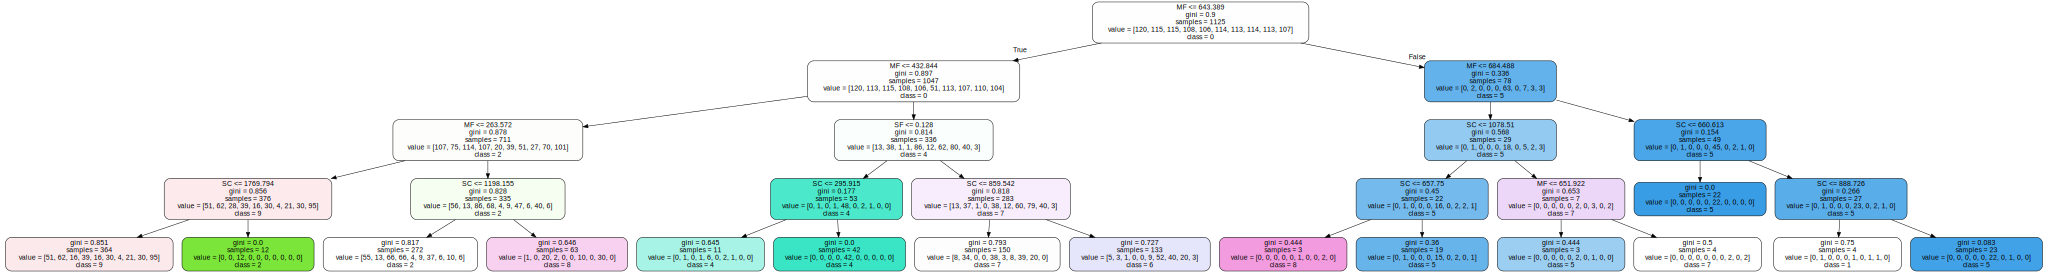

In [68]:
class_names = [str(c) for c in model.classes_]

# visualize the decision tree
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=features,  
                         class_names=class_names,  
                         filled=True, rounded=True) 

graph = graphviz.Source(dot_data)  
graph 

## Evaluate on Test Data

In [0]:
# Visualize the confusion matrix
def plot_cmatrix(cm,labels,title='Confusion Matrix'):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm,cmap='Reds')
  plt.title('\n'+title+'\n', fontsize=20)
  fig.colorbar(cax)
  ax.set_xticks(range(len(labels)))
  ax.set_yticks(range(len(labels)))
  ax.set_xticklabels(labels, fontsize=16)
  ax.set_yticklabels(labels, fontsize=16)
  plt.xlabel('Predicted', fontsize=16)
  plt.ylabel('True', fontsize=16)
  plt.show()

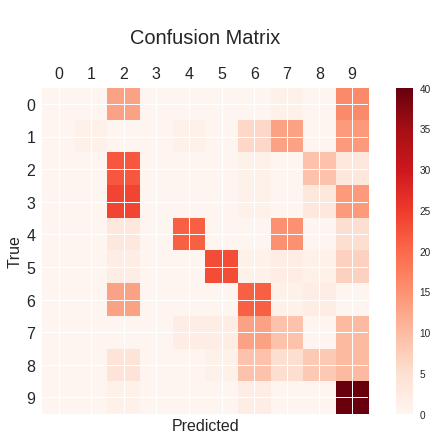

In [70]:
# Predict class label probabilities
labels=np.sort(y_test.unique())
y_test_pred = model.predict(X_test)

cm = metrics.confusion_matrix(y_test,y_test_pred, labels)
plot_cmatrix(cm, labels)

# Exercises:

1. Instead of predicting the speaker, try to predict the digits
2. Extract some other features from the signals
3. Try using different ML algorithms